# Lungs Segmentation
The segmentation of lungs may, possibly, proceed directly in 3D as follows:
1. Run binarization of the CT image using a threshold of -320 HU – every voxel
with HU lower than this threshold should receive label 1 (air label) and the
remaining voxels should receive label 0
2. Use body mask to select only air regions within body
3. Design a sequence of morphological (and other appropriate) operations to fill
the holes in the interior of lungs and to remove ‘air’ clusters which do not
correspond to lungs (e.g. gas in bowels) – at the end one should be left with
clusters which correspond only to airways
4. Use watershed from markers (scikit-image -> segmentation -> watershed) to
extract the left and the right lung from the segmentation being the result of step
(3) above. Before using watershed design a procedure for defining the three
markers (marker of left lung, marker of right lung, marker of background).
5. To compare segmentation results with reference segmentations available at
Lab One Drive use Dice coefficient and Hausdorff distance (find the definitions of
these   quantities)   as   implemented   in   surface-distance   [package](https://github.com/google-deepmind/surface-distance).
The project results (Dice coefficients and Hausdorff distance) should be
reported   for   the   three   tasks:   body   mask   segmentation,   left   lung
segmentation, right lung segmentation.


## Imports

In [81]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from skimage.filters import rank
from scipy import ndimage
import matplotlib.pyplot as plt

import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import reconstruction
from skimage.segmentation import flood, flood_fill
from sklearn import cluster
from skimage.segmentation import watershed

from surface_distance import metrics

## Load / save .nii files and Visualization

In [82]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photo(img: np.ndarray, photo_title: str, *slices: int) -> None:
    print(f"Visualizing {photo_title}")
    plt.figure(figsize=(5 * len(slices), 5)) 
    
    for i, slice_num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.title(f"photo Slice {slice_num}")
        plt.imshow(img[:, :, slice_num], cmap="gray")
        
    plt.tight_layout() 
    plt.show()
    
def visualize_photo_with_centers(img: np.ndarray, photo_title: str, centers: np.ndarray, *slices: int) -> None:
    print(f"Visualizing {photo_title}")
    plt.figure(figsize=(5 * len(slices), 5)) 
    
    for i, slice_num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.title(f"photo Slice {slice_num}")
        plt.imshow(img[:, :, slice_num], cmap="gray")

        for (_, x, y) in centers:
            plt.scatter(x, y, color="red", s=100, marker="o") 
        
    plt.tight_layout() 
    plt.show()    
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()
    
def plot_histogram(img: np.ndarray) -> None:
    plt.hist(img.ravel(), bins=256, range=(img.min()+1, img.max()-1), fc='k', ec='k')
    plt.axvline(x=-320, color='red', linestyle='--', linewidth=1.5)
    plt.show()

## Binarize functions

In [83]:
THR_HU = -320

def binarize(image: np.ndarray, threshold: float = THR_HU) -> np.ndarray:
    res = image.copy()
    res[image >= threshold] = 1
    res[image < threshold] = 0
    return res

## Body Mask

In [84]:
def resize_3d_image(img: np.ndarray, output_shape: tuple) -> np.ndarray:
    sizes = img.shape
    resized_img = np.zeros((output_shape[0], output_shape[1], sizes[2]), dtype=img.dtype)
    
    for i in range(img.shape[2]):
        resized_img[:,:,i] = cv2.resize(img[:,:,i], (output_shape[0], output_shape[1]), interpolation=cv2.INTER_LINEAR) 
    
    return resized_img


def medianBlur(img: np.ndarray, kernel_size: int) -> np.ndarray:
    sizes = img.shape
    blurred = np.zeros_like(img)
    
    for i in range(sizes[2]):
        blurred[:,:,i] = cv2.medianBlur(img[:,:,i], kernel_size)
    
    return blurred

def prepare_before_body_mask(img: np.ndarray) -> np.ndarray:
    binary_image = binarize(img, THR_HU)
    binary_image = ndimage.binary_fill_holes(binary_image)
    binary_image = morphology.binary_opening(binary_image, morphology.ball(2))
    binary_image = morphology.binary_closing(binary_image, morphology.ball(2))
    return binary_image


def reconstruct_3d(img: np.ndarray) -> np.ndarray:
    labels = label(img, connectivity=1)
    regions = regionprops(labels)
    largest_region = max(regions, key=lambda x: x.area)
    largest_region_mask = labels == largest_region.label
    
    mask = largest_region_mask
    neg_mask = np.logical_not(mask)
    
    seed = np.zeros_like(mask)
    list_of_corners = [(0, 0, 0), (0, 0, -1), (0, -1, 0), (-1, 0, 0), (-1, -1, -1), (-1, -1, 0), (-1, 0, -1), (0, -1, -1)]
    for corner in list_of_corners:
        seed[corner] = 1
    
    reconstructed = reconstruction(seed, neg_mask)
    insert_part = 1 - reconstructed
    
    return insert_part

def create_body_mask(img: np.ndarray) -> np.ndarray:
    binary_image = prepare_before_body_mask(img)
    body_mask = reconstruct_3d(binary_image)
    return body_mask

## Lungs segmentation

In [86]:
def lungs_initial_transform(img: np.ndarray, body_mask: np.ndarray) -> np.ndarray:
    lungs = cut_out_body(img, body_mask)
    lungs = binarize(lungs, THR_HU)
    lungs = body_mask - lungs
    lungs = abs(lungs)
    lungs = morphology.binary_closing(lungs, morphology.ball(3))
    lungs = morphology.binary_opening(lungs, morphology.ball(3))
    return lungs

def kmeans_clusterization(img: np.ndarray) -> np.ndarray:
    markers_x, markers_y, markers_z = np.nonzero(img)
    
    initial_clusters = cluster.KMeans(n_clusters=2)
    _ = initial_clusters.fit_predict(np.stack((markers_x, markers_y, markers_z), axis=-1))
    initial_centers = initial_clusters.cluster_centers_
    
    centers = []
    for center in initial_centers:
        center_x, center_y, center_z = center
        distances = ((markers_x - center_x) ** 2 + (markers_y - center_y) ** 2 + (markers_z - center_z) ** 2) ** 0.5
        closest_index = np.argmin(distances)
        centers.append((markers_x[closest_index], markers_y[closest_index], markers_z[closest_index]))
    
    visualize_photo_with_centers(img, "After kmeans with centers", centers, 50, 70, 100, 120)
    centers = np.array(centers)
    centers = centers[centers[:, 1].argsort()] # sorting centers by x coordinate
    return np.array(centers)

def watershed_segmentation(img: np.ndarray, centers: tuple) -> np.ndarray:
    markers = np.zeros(img.shape, dtype=np.int32)

    for i, center in enumerate(centers):
        center_3d_point = tuple(np.round(center).astype(int))
        print(f"Center point {center_3d_point}")

        if 0 <= center_3d_point[0] < img.shape[0] and 0 <= center_3d_point[1] < img.shape[1]:
            markers[center_3d_point] = i + 1  
            
    gradient = rank.gradient(img, morphology.ball(2))
    return watershed(gradient, markers, mask=img)

def cut_out_body(img: np.ndarray, body_mask: np.ndarray) -> np.ndarray:
    res = img.copy()
    res = img * body_mask + img.min() * (1 - body_mask)
    return res

## Compare with reference

In [87]:
class Scores:
    def __init__(self, img: np.ndarray, ref_img: np.ndarray, centers: np.ndarray, body_masks: np.ndarray, body_masks_ref: np.ndarray) -> None:
        self.img: np.ndarray = img
        self.ref_img: np.ndarray = ref_img
        self.body_masks = body_masks
        self.body_masks_ref = body_masks_ref
        plt.imshow(self.img[..., 80], cmap='gray')
        plt.show()
        self.centers = centers
        self.my_left_lung, self.my_right_lung = self.__get_lungs_from_labels(image=self.img, left_label=1, right_label=2)
        self.ref_left_lung, self.ref_right_lung = self.__get_lungs_from_labels(image=self.ref_img, left_label=2, right_label=3)
        
    def __get_lungs_from_labels(self, image: np.ndarray, left_label: int, right_label: int) -> tuple[np.ndarray, np.ndarray]:
        left_lung = np.where(image == left_label, 1, 0)
        right_lung = np.where(image == right_label, 1, 0)
        return left_lung, right_lung
        
    def calculate_dice_coef(self)-> tuple[np.float64, np.float64]:
        dice_coef_left = metrics.compute_dice_coefficient(self.my_left_lung.astype(np.bool), self.ref_left_lung.astype(np.bool))
        dice_coef_right = metrics.compute_dice_coefficient(self.my_right_lung.astype(np.bool), self.ref_right_lung.astype(np.bool))
        dice_coef_body_masks = metrics.compute_dice_coefficient(self.body_masks.astype(np.bool), self.body_masks_ref.astype(np.bool))
        return dice_coef_left, dice_coef_right, dice_coef_body_masks
    
    def caculate_hausdorff_distance(self) -> tuple[np.float64, np.float64]:
        left_surf_distances = metrics.compute_surface_distances(self.my_left_lung.astype(np.bool), self.ref_left_lung.astype(np.bool), (1, 1, 1))
        right_surf_distances = metrics.compute_surface_distances(self.my_right_lung.astype(np.bool), self.ref_right_lung.astype(np.bool), (1, 1, 1))
        body_mask_distances = metrics.compute_surface_distances(self.body_masks.astype(np.bool), self.body_masks_ref.astype(np.bool), (1, 1, 1))
        
        hausdorff_left = metrics.compute_robust_hausdorff(left_surf_distances, 95)
        hausdorff_right = metrics.compute_robust_hausdorff(right_surf_distances, 95)
        hausdorff_body_mask = metrics.compute_robust_hausdorff(body_mask_distances, 95)
        
        return hausdorff_left, hausdorff_right, hausdorff_body_mask
    
    def plot_lungs(self) -> None:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.title('My left lung')
        plt.imshow(self.my_left_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 2)
        plt.title('Reference left lung')
        plt.imshow(self.ref_left_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 3)
        plt.title('My right lung')
        plt.imshow(self.my_right_lung[..., 50], cmap='gray')
        plt.subplot(1, 4, 4)
        plt.title('Reference right lung')
        plt.imshow(self.ref_right_lung[..., 50], cmap='gray')
        plt.show()

## Main

In [88]:
def run(img_path: str,reference_img_path: str, body_mask_path: str) -> tuple:
    print(f"~~~ {img_path} ~~~")
    img, affine = load_nii_gz_file(img_path)
    body_masks_ref, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # BODY MASK
    visualize_photo(img, "Input image resized", 50, 70, 100, 120)
    plot_histogram(img)
        
    img_for_mask = prepare_before_body_mask(img)
    body_mask = reconstruct_3d(img_for_mask)
    visualize_photo(body_mask, "Body mask done", 50, 70, 100, 120)
    
    # LUNGS
    lungs = lungs_initial_transform(img, body_mask)
    centers = kmeans_clusterization(lungs)
    result = watershed_segmentation(lungs, centers)
    visualize_photo(result, "Watershed done", 50, 70, 100, 120)
    body_mask = resize_3d_image(body_mask.astype("float32"), (img.shape[0], img.shape[1]))
    result = resize_3d_image(result.astype("float32"), (img.shape[0], img.shape[1]))
 
    
    scores = Scores(result, reference_img, centers, body_mask, body_masks_ref)
    left_dice_score, right_dice_score, body_masks_score = scores.calculate_dice_coef()
    print(f"Left lung dice coefficient: {left_dice_score}, Right lung dice coefficient: {right_dice_score}, Body masks dice coefficient: {body_masks_score}")
    # left_hausdorff, right_hausdorff, body_mask_hausdorff = scores.caculate_hausdorff_distance()
    # print(f"Left lung hausdorff: {left_hausdorff}, Right lung hausdorff: {right_hausdorff}, Body masks hausdorff: {body_mask_hausdorff}")
    
    # VISUALIZE
    scores.plot_lungs()
     
    return left_dice_score, right_dice_score, body_masks_score
    

## Run code

In [89]:
def run_all_tests(inputs, references, body_masks):
    left_scores = []
    right_scores = []
    body_mask_scores = []
    for i in range(len(inputs)):
        cur_input = inputs[i]
        reference = references[i]
        body_mask = body_masks[i]
        left, right, body_masks_score = run(cur_input, reference, body_mask)
        # run(cur_input, reference, body_mask)
        left_scores.append(left)
        right_scores.append(right)
        body_mask_scores.append(body_masks_score)
        
    print(f"Average left lung dice coefficient: {np.mean(left_scores)}, Average right lung dice coefficient: {np.mean(right_scores)}, Average body masks dice coefficient: {np.mean(body_mask_scores)}")

~~~ Images/IMG_0019.nii.gz ~~~


Visualizing Input image resized


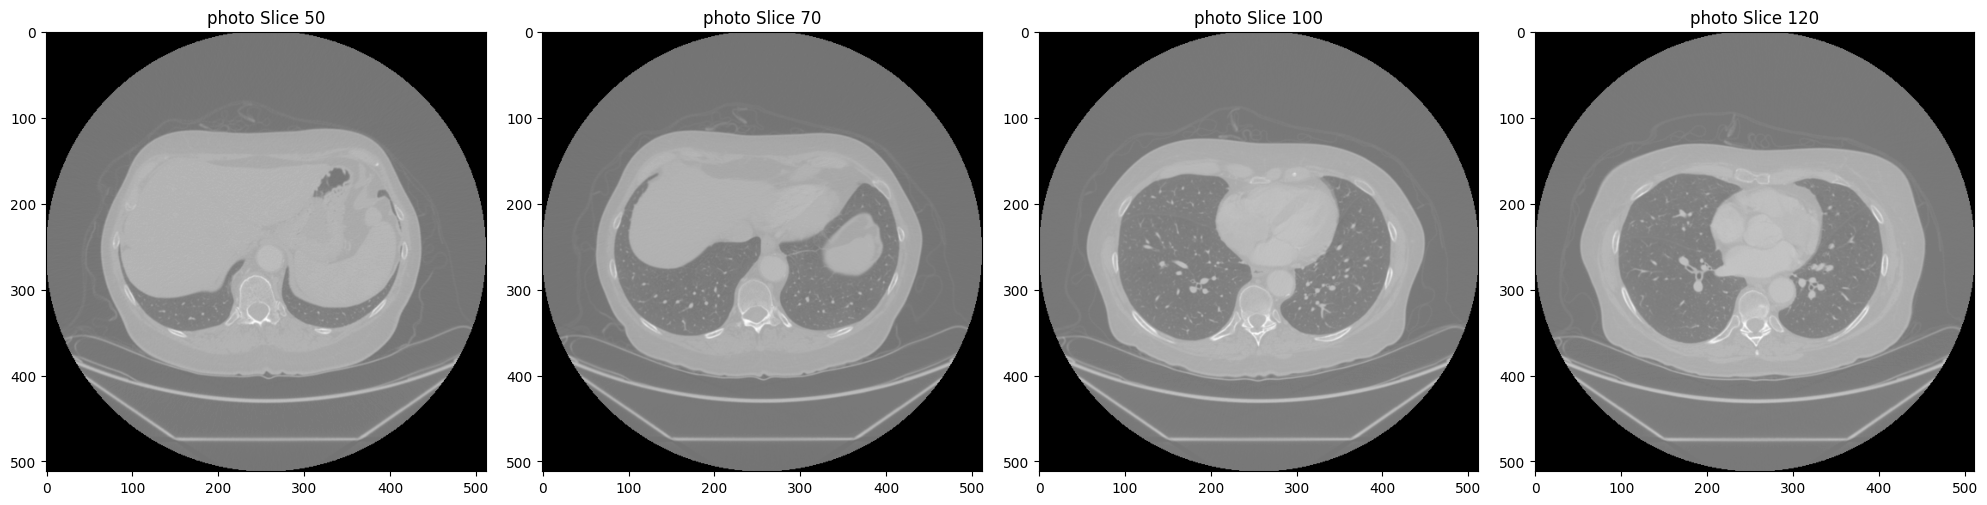

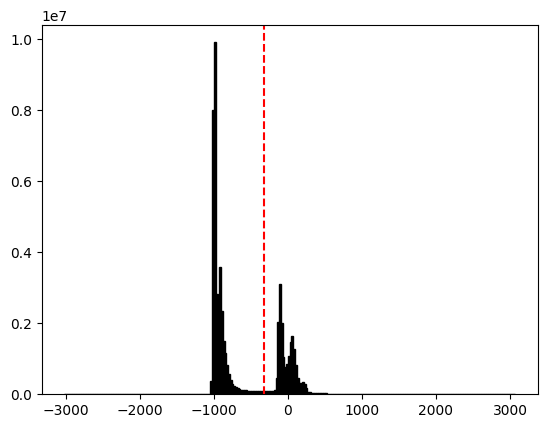

Visualizing Body mask done


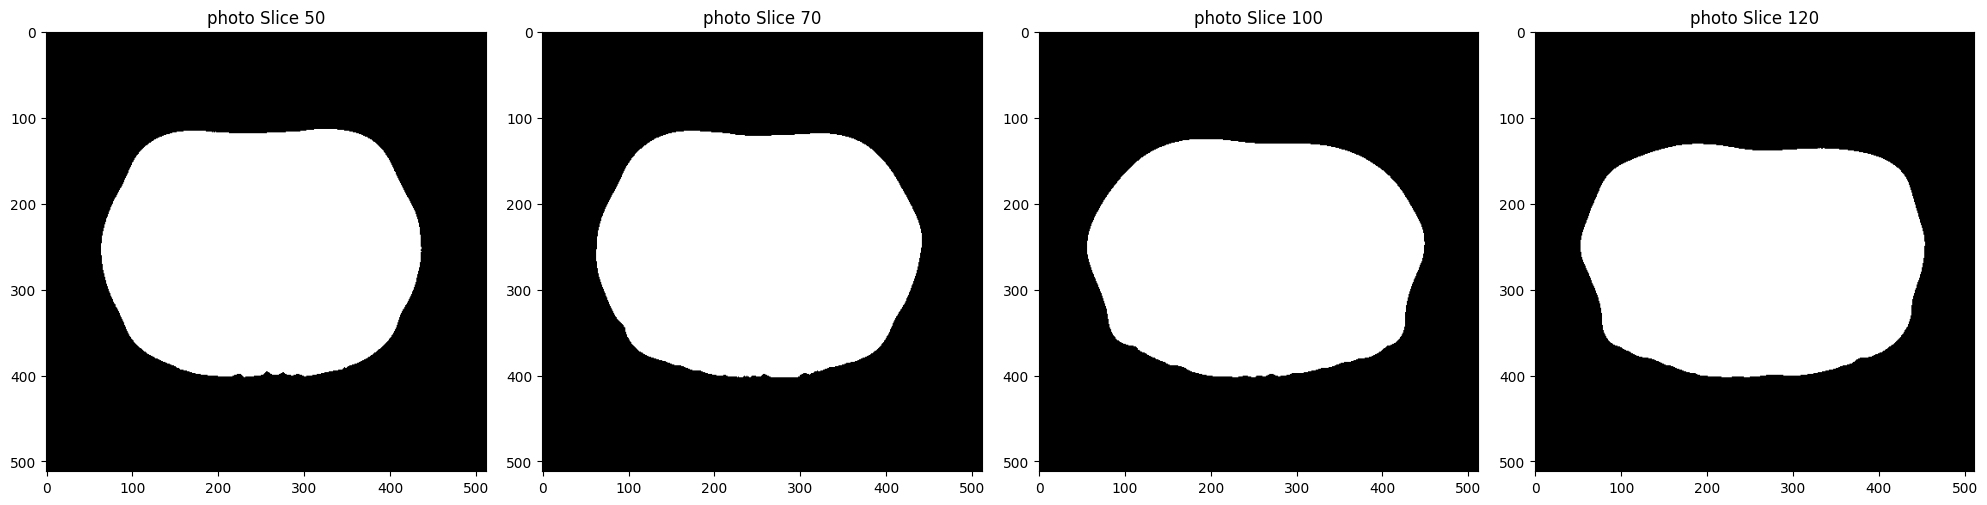

Visualizing After kmeans with centers


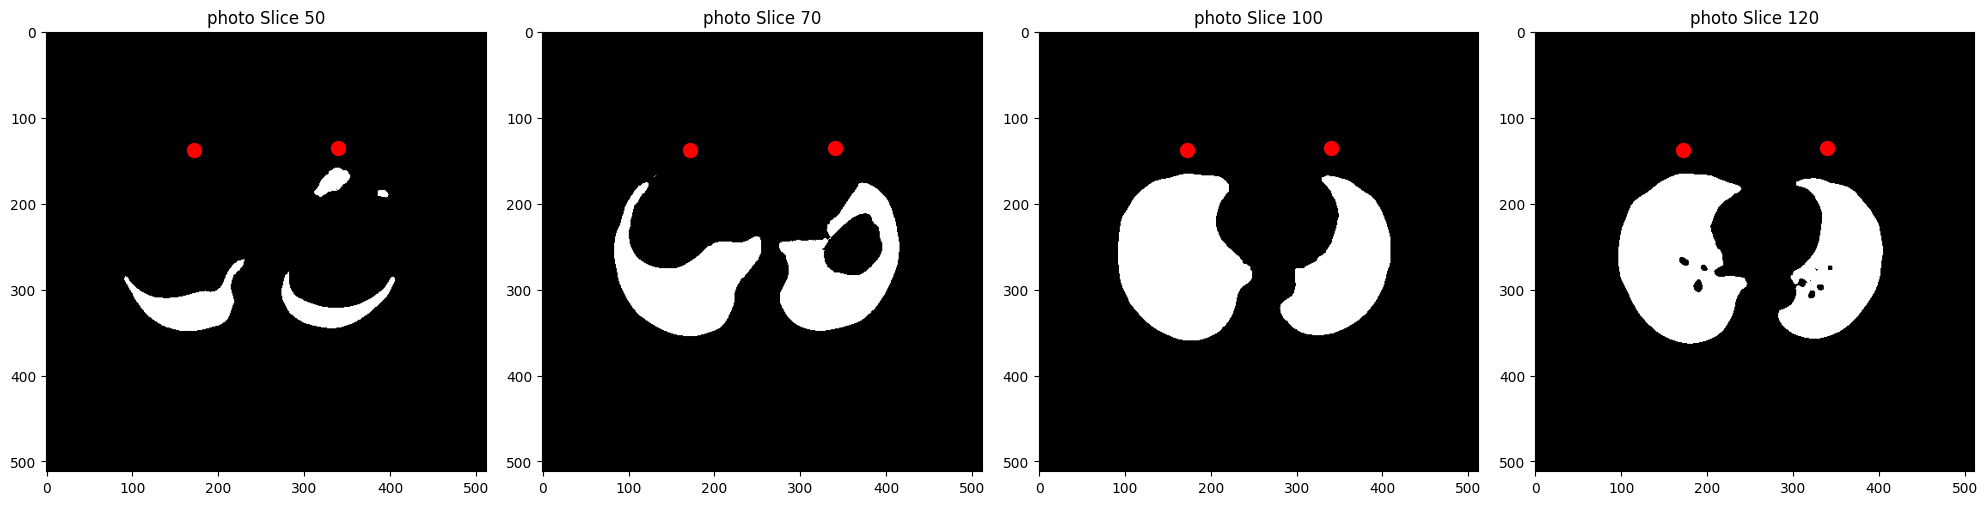

Center point (np.int64(274), np.int64(172), np.int64(137))
Center point (np.int64(272), np.int64(340), np.int64(135))


/home/lenovo/Projects/OpenCVAndAI/.venv/lib/python3.12/site-packages/skimage/filters/rank/generic.py:353: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, footprint, out, mask, n_bins = _handle_input_3D(


Visualizing Watershed done


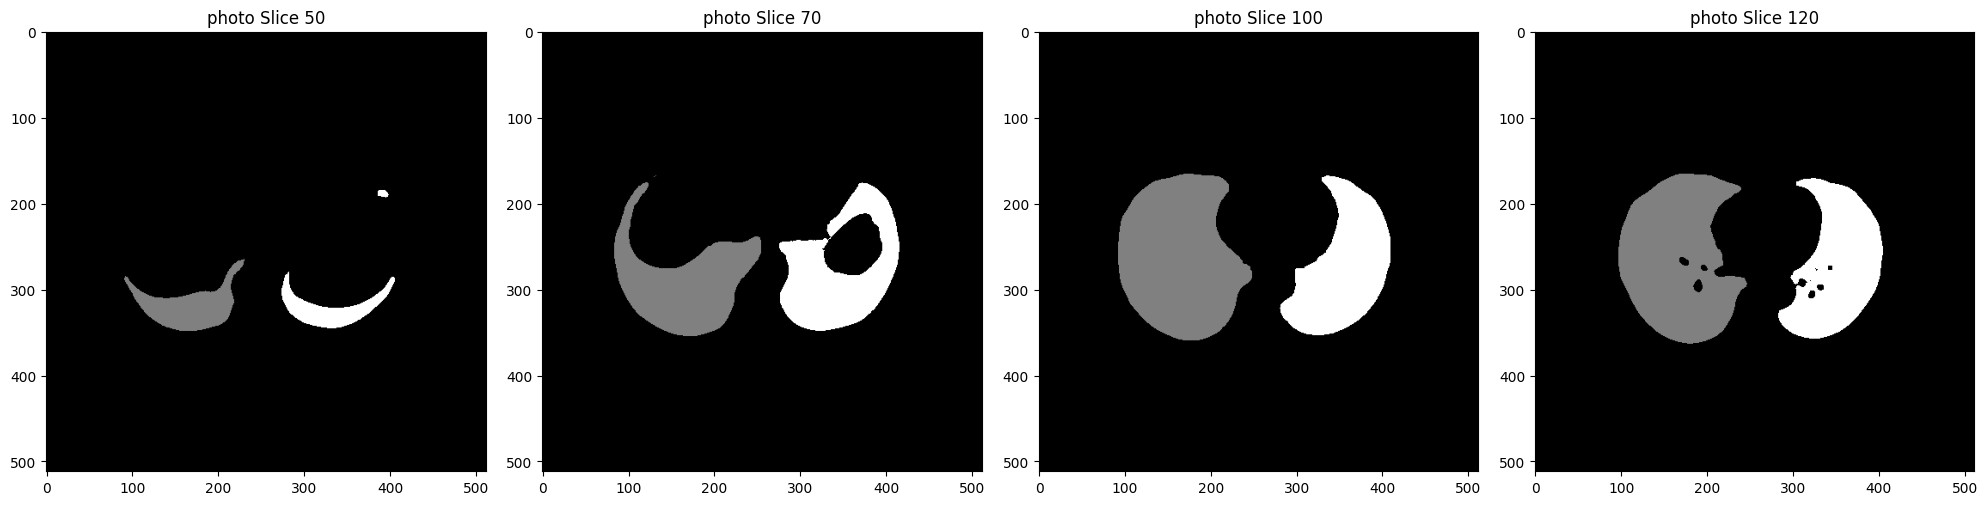

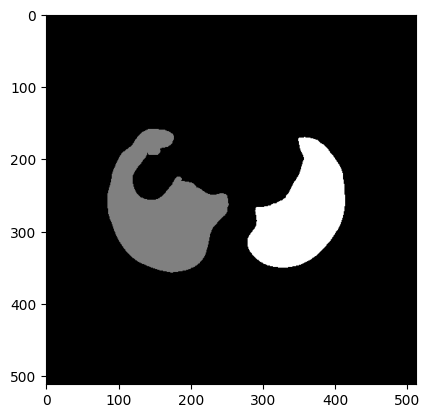

Left lung dice coefficient: 0.9839573362940457, Right lung dice coefficient: 0.9875813303410768, Body masks dice coefficient: 0.9975689196048131


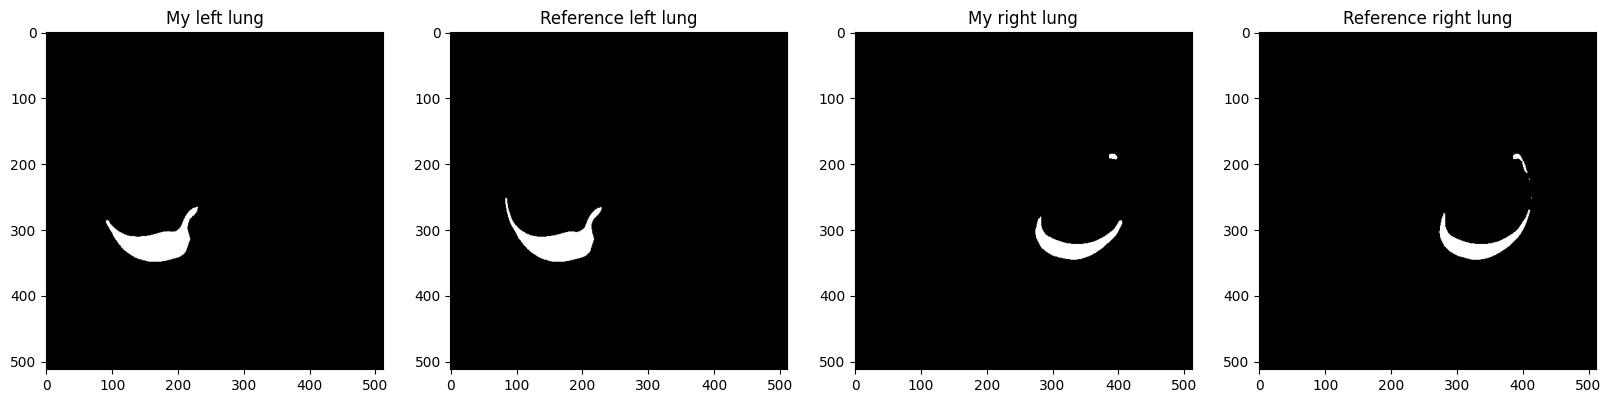

~~~ Images/IMG_0011.nii.gz ~~~
Visualizing Input image resized


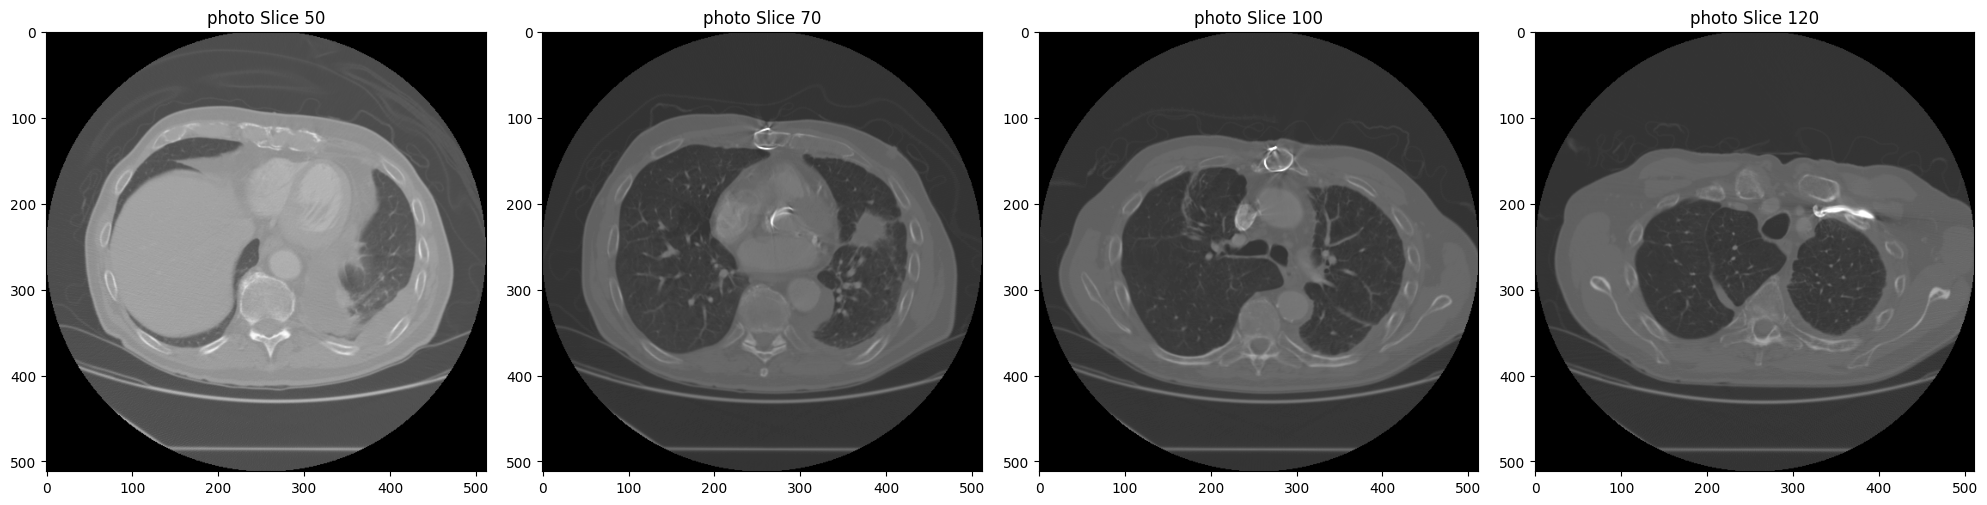

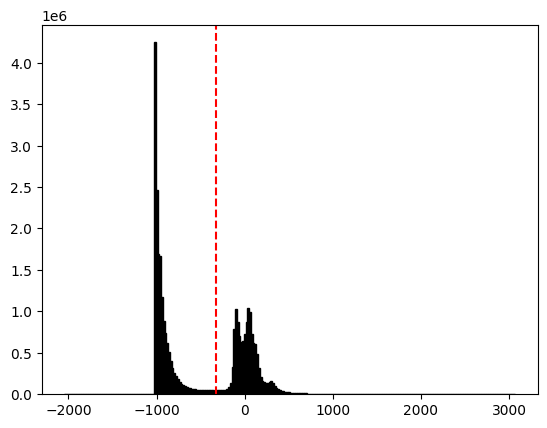

Visualizing Body mask done


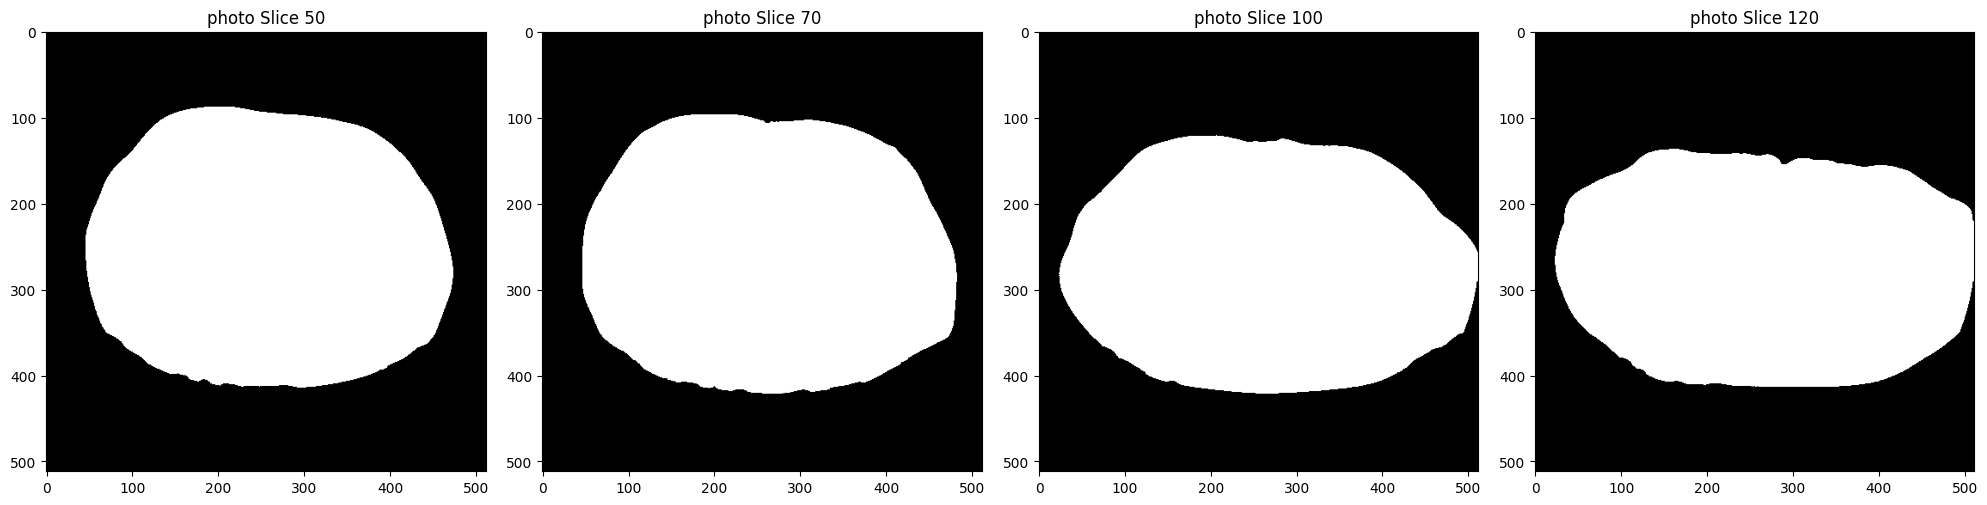

Visualizing After kmeans with centers


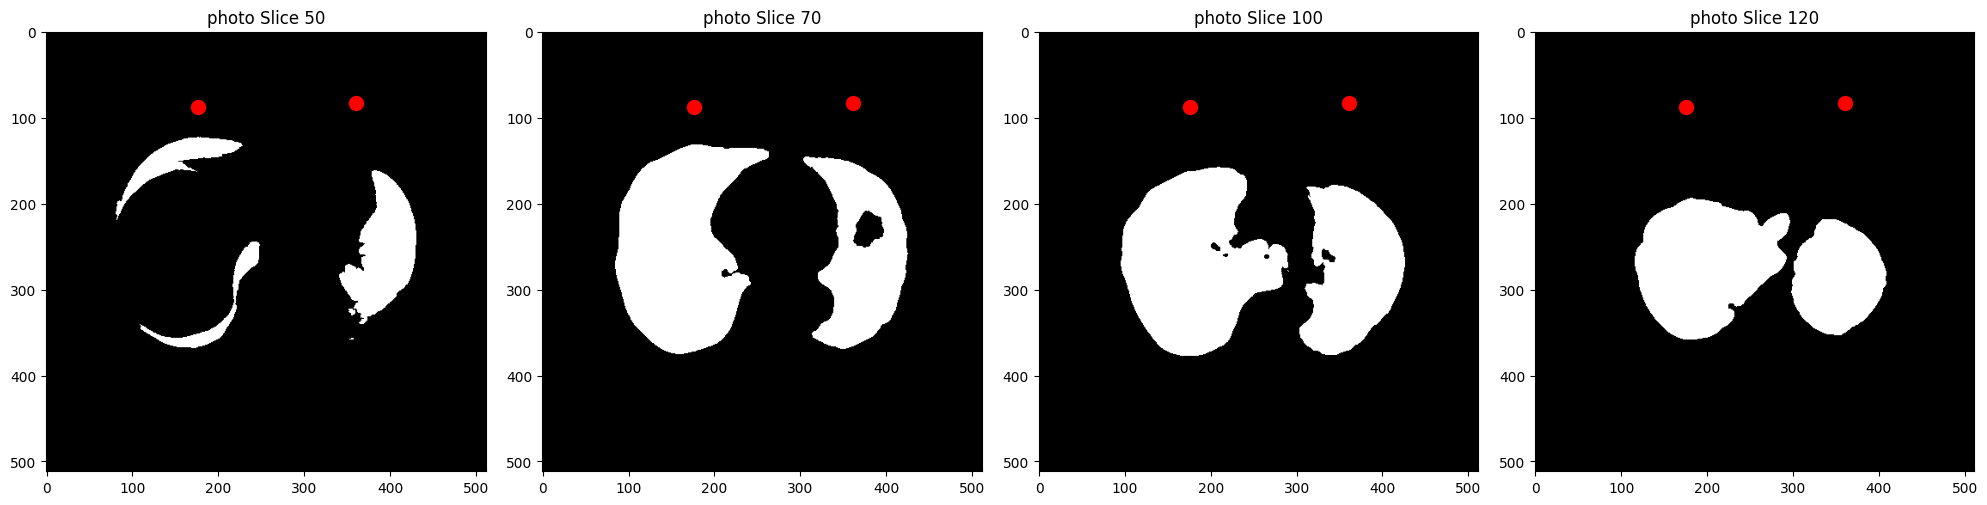

Center point (np.int64(257), np.int64(176), np.int64(87))
Center point (np.int64(260), np.int64(361), np.int64(83))


/home/lenovo/Projects/OpenCVAndAI/.venv/lib/python3.12/site-packages/skimage/filters/rank/generic.py:353: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, footprint, out, mask, n_bins = _handle_input_3D(


Visualizing Watershed done


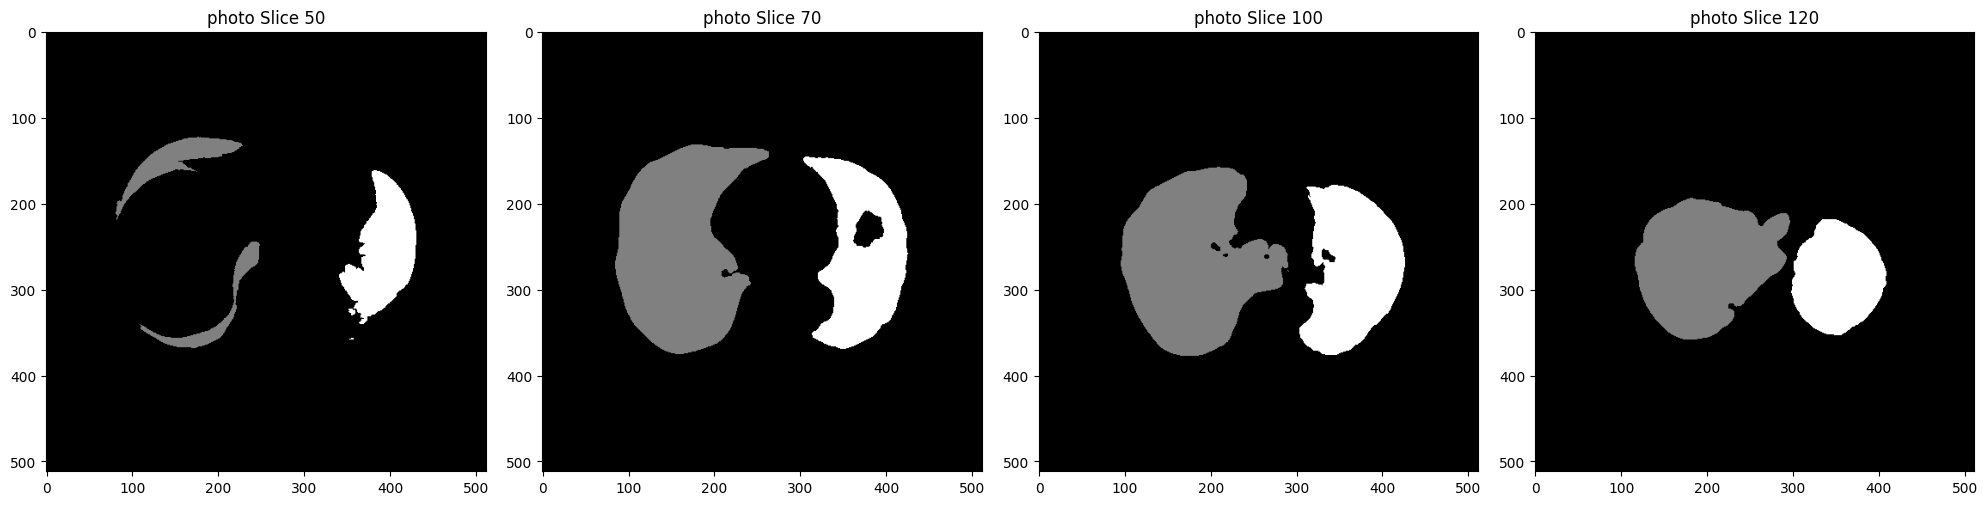

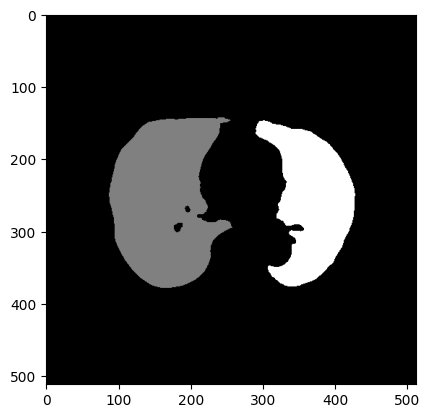

Left lung dice coefficient: 0.9756419521799129, Right lung dice coefficient: 0.8983962499181994, Body masks dice coefficient: 0.9968108101428619


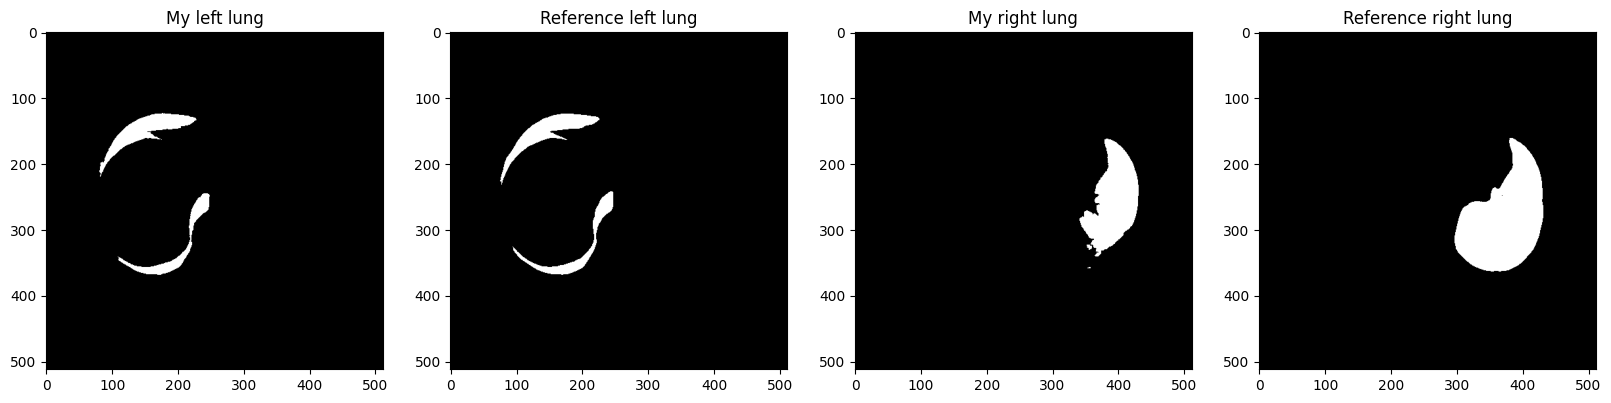

~~~ Images/IMG_0014.nii.gz ~~~
Visualizing Input image resized


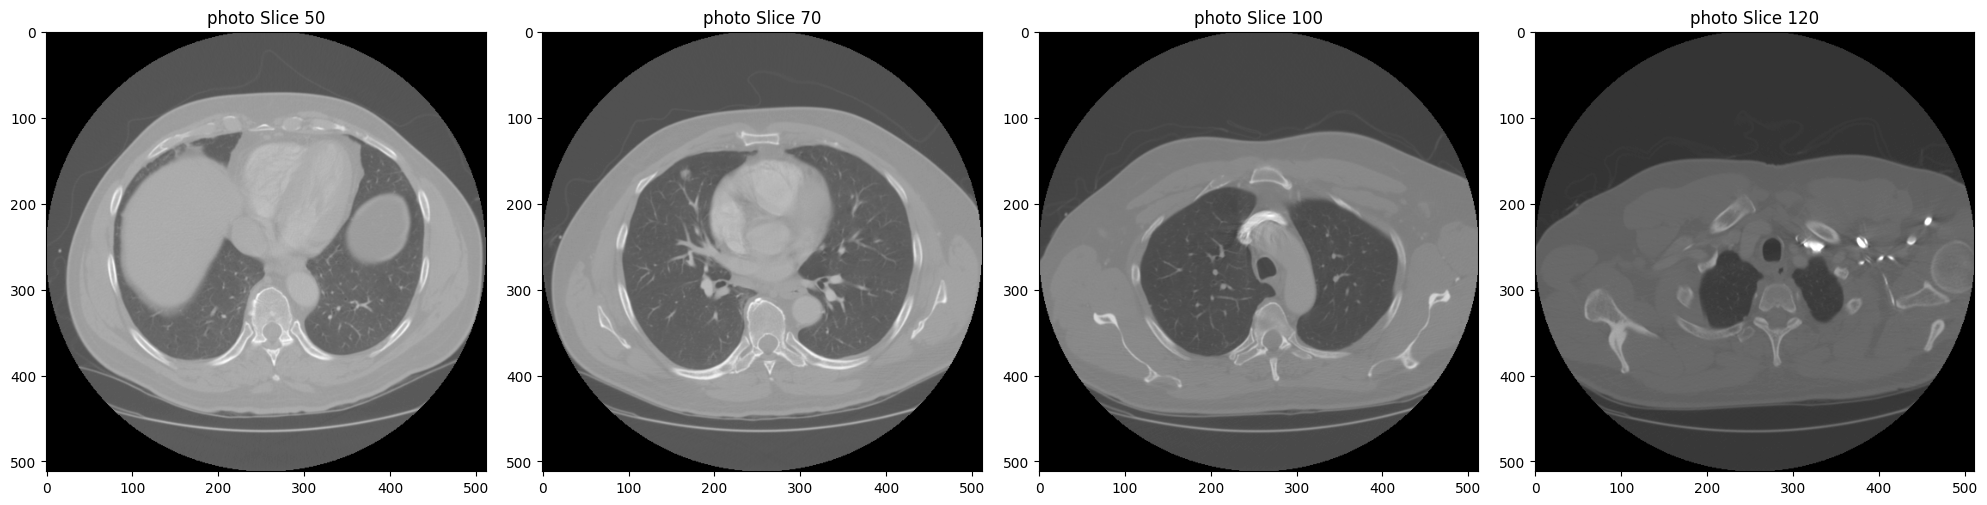

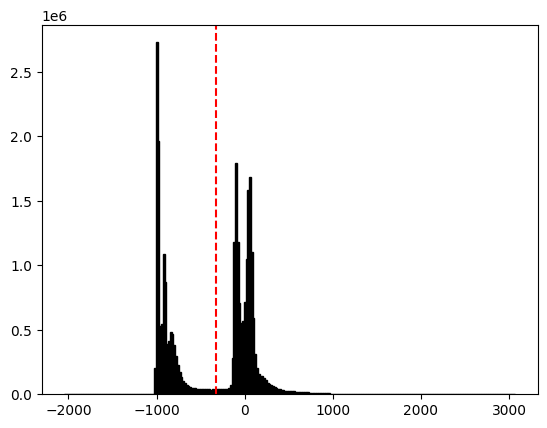

Visualizing Body mask done


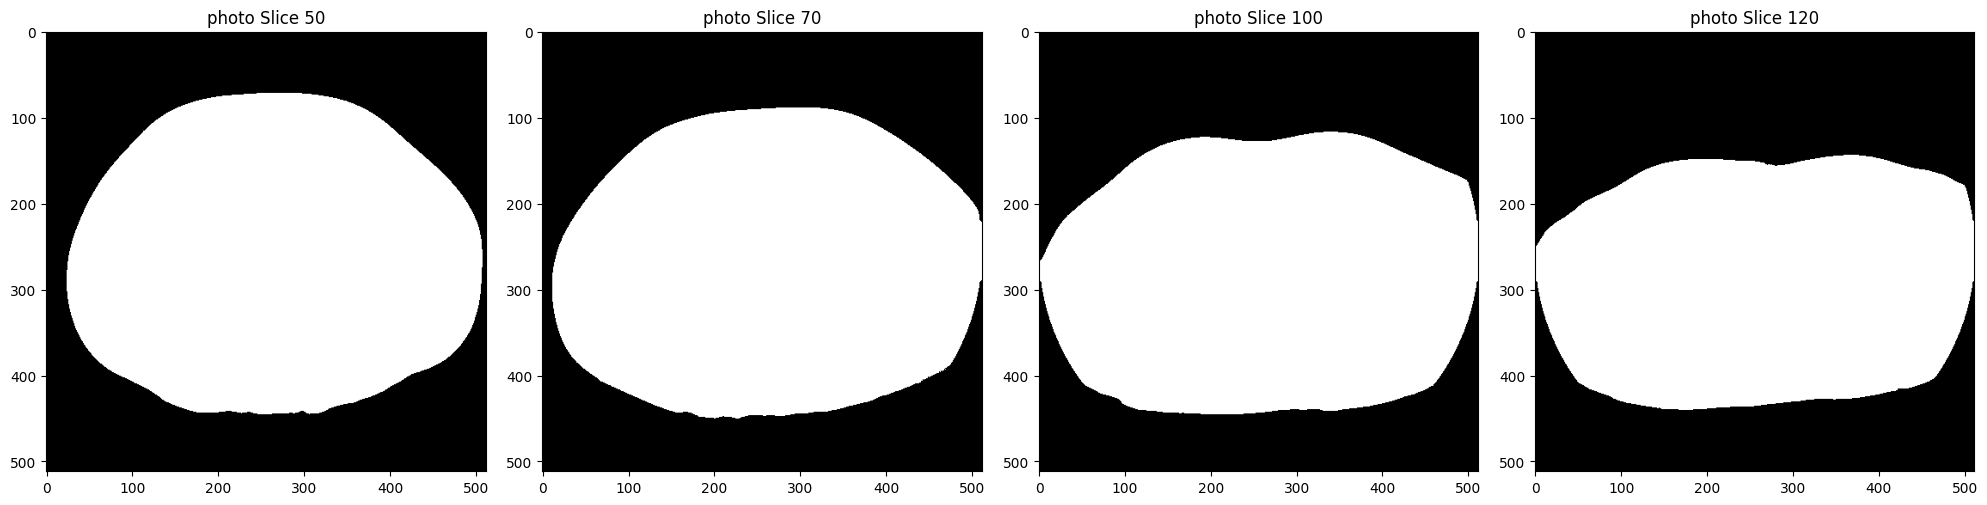

Visualizing After kmeans with centers


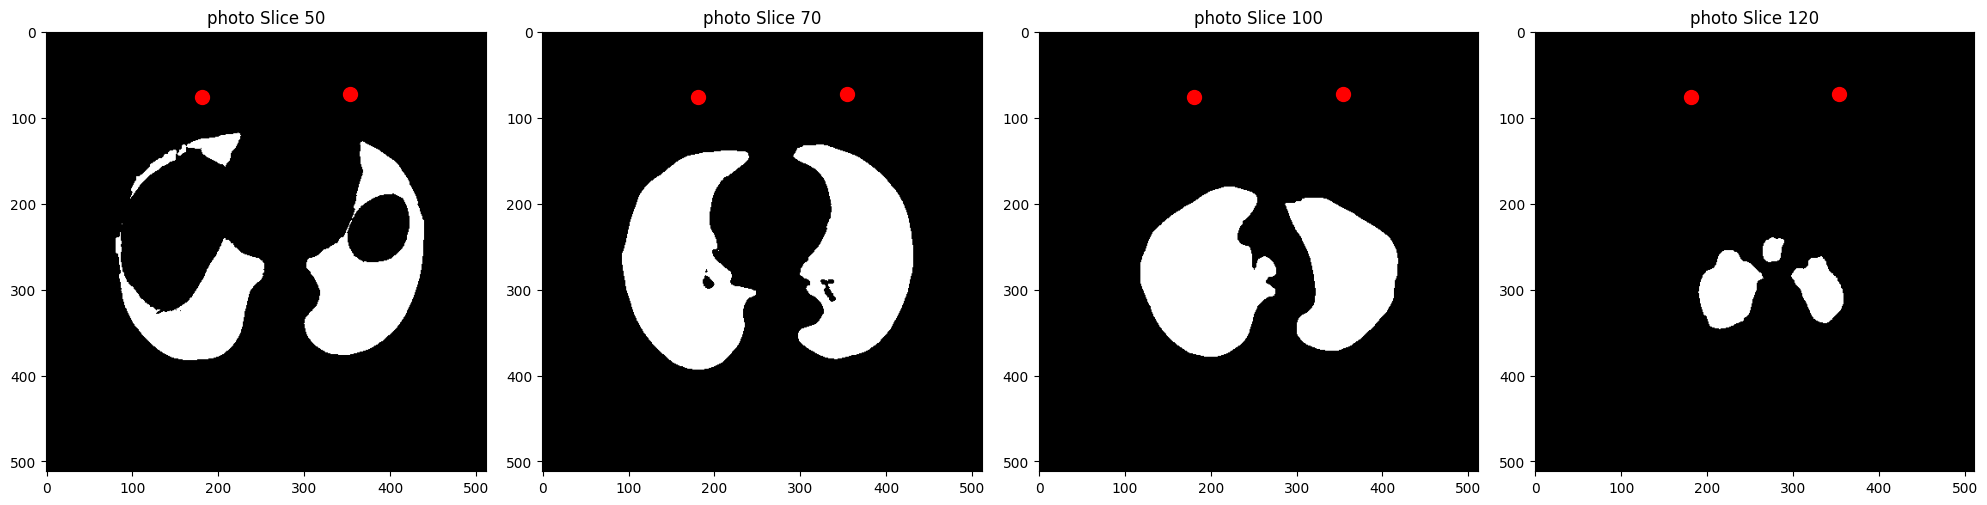

Center point (np.int64(270), np.int64(181), np.int64(76))
Center point (np.int64(258), np.int64(354), np.int64(72))


/home/lenovo/Projects/OpenCVAndAI/.venv/lib/python3.12/site-packages/skimage/filters/rank/generic.py:353: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, footprint, out, mask, n_bins = _handle_input_3D(


Visualizing Watershed done


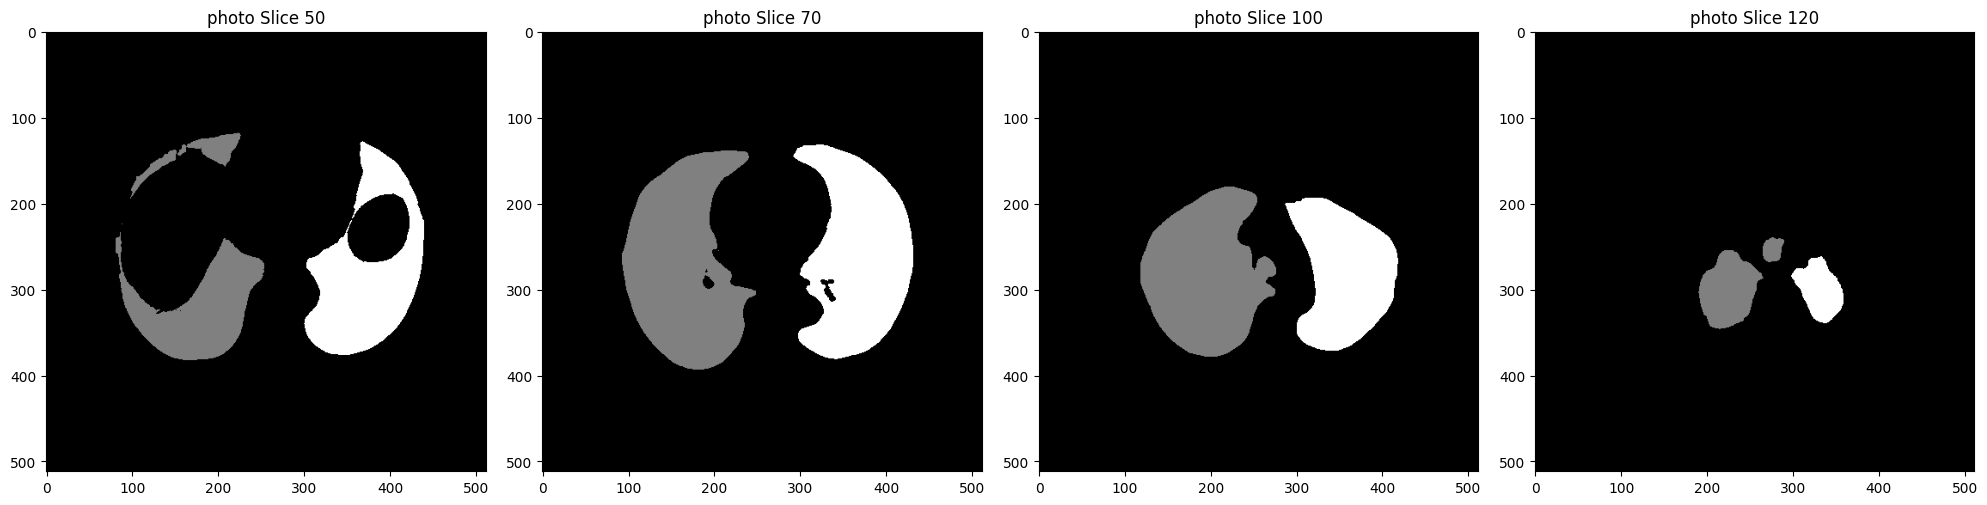

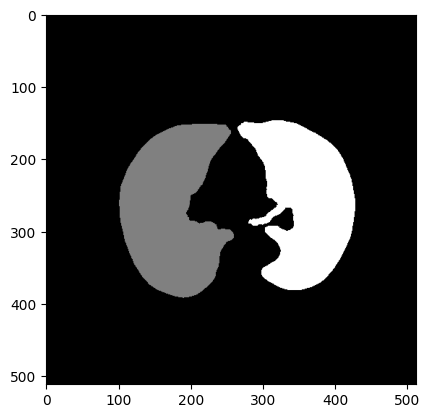

Left lung dice coefficient: 0.9769236319125857, Right lung dice coefficient: 0.9126350681406916, Body masks dice coefficient: 0.9975475435969547


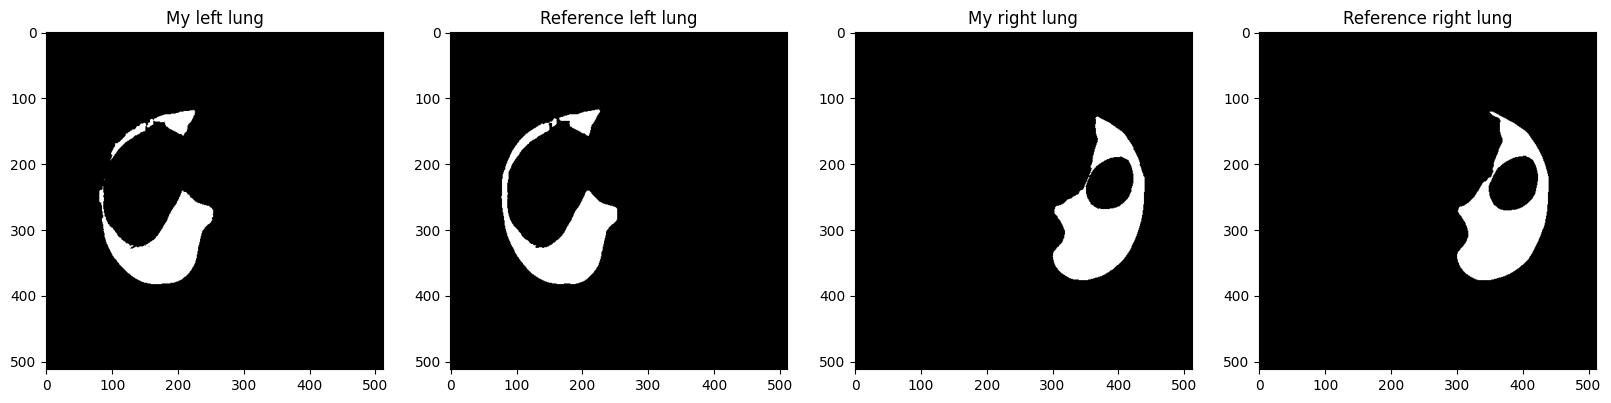

Average left lung dice coefficient: 0.9788409734621815, Average right lung dice coefficient: 0.9328708827999893, Average body masks dice coefficient: 0.9973090911148766


In [90]:
# inputs = ['Images/IMG_0001.nii.gz', 'Images/IMG_0007.nii.gz', 'Images/IMG_0010.nii.gz', 'Images/IMG_0011.nii.gz', 'Images/IMG_0012.nii.gz', 'Images/IMG_0013.nii.gz', 'Images/IMG_0014.nii.gz', 'Images/IMG_0015.nii.gz', 'Images/IMG_0016.nii.gz', 'Images/IMG_0017.nii.gz', 'Images/IMG_0018.nii.gz', 'Images/IMG_0019.nii.gz', 'Images/IMG_0027.nii.gz', 'Images/IMG_0028.nii.gz',]
# references = ['ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0007.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0010.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0011.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0012.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0013.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0014.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0015.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0016.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0017.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0018.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0019.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0027.nii.gz', 'ReferenceSegmentations/LUNGS_IMG_0028.nii.gz',]
# body_masks = ['BodyMasks/BODYMASK_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0007.nii.gz', 'BodyMasks/BODYMASK_IMG_0010.nii.gz', 'BodyMasks/BODYMASK_IMG_0011.nii.gz', 'BodyMasks/BODYMASK_IMG_0012.nii.gz', 'BodyMasks/BODYMASK_IMG_0013.nii.gz', 'BodyMasks/BODYMASK_IMG_0014.nii.gz', 'BodyMasks/BODYMASK_IMG_0015.nii.gz', 'BodyMasks/BODYMASK_IMG_0016.nii.gz', 'BodyMasks/BODYMASK_IMG_0017.nii.gz', 'BodyMasks/BODYMASK_IMG_0018.nii.gz', 'BodyMasks/BODYMASK_IMG_0019.nii.gz', 'BodyMasks/BODYMASK_IMG_0027.nii.gz', 'BodyMasks/BODYMASK_IMG_0028.nii.gz',]

dataset_numbers: list[str] = ['0019', '0011', '0014'] #, '0015'] 
inputs = [f'Images/IMG_{i}.nii.gz' for i in dataset_numbers]
body_masks = [f'BodyMasks/BODYMASK_IMG_{i}.nii.gz' for i in dataset_numbers]
references = [f'ReferenceSegmentations/LUNGS_IMG_{i}.nii.gz' for i in dataset_numbers]


run_all_tests(inputs, references, body_masks)
